In [1]:
import datetime
import glob
import json
import os
from collections import defaultdict
from pathlib import Path
import traceback
import time
import warnings
import copy
import pathlib

import awkward as ak
import dask
import dask_awkward as dak
import hist.dask
import coffea
import numpy as np
import uproot
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("ggplot")

from coffea.nanoevents import NanoEventsFactory, PHYSLITESchema
from coffea import dataset_tools

import urllib
import utils
import warnings

warnings.filterwarnings("ignore")

# import input_files.utils

from dask.distributed import LocalCluster, Client, progress, performance_report

# local: single thread, single worker
# cluster = LocalCluster(n_workers=1, processes=False, threads_per_worker=1)
# client = Client(cluster)

# for UChicago
# update this to point to your own client!
# client = Client("tls://localhost:8786")

# create a folder for output tracking of uproot.open setup
MEASUREMENT_PATH = pathlib.Path(datetime.datetime.now().strftime("measurements/%Y-%m-%d_%H-%M-%S"))
os.makedirs(MEASUREMENT_PATH)

print(f"awkward: {ak.__version__}")
print(f"dask-awkward: {dak.__version__}")
print(f"uproot: {uproot.__version__}")
print(f"hist: {hist.__version__}")
print(f"coffea: {coffea.__version__}")

/usr/local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


awkward: 2.6.3
dask-awkward: 2024.3.0
uproot: 5.3.2
hist: 2.7.2
coffea: 2024.4.0


In [2]:
mc_file = "https://cernbox.cern.ch/remote.php/dav/public-files/BPIO76iUaeYuhaF/DAOD_PHYSLITE.37233417._000052.pool.root.1"

# download for subsequent use
local_file_name = "ttbar.root"
if not os.path.exists(local_file_name):
    urllib.request.urlretrieve(mc_file, filename=local_file_name)

    
def filter_name(name):
    return name in [
        "AnalysisElectronsAuxDyn.pt",
        "AnalysisElectronsAuxDyn.eta",
        "AnalysisElectronsAuxDyn.phi",
        "AnalysisElectronsAuxDyn.m",
        
        "AnalysisMuonsAuxDyn.pt",
        "AnalysisMuonsAuxDyn.eta",
        "AnalysisMuonsAuxDyn.phi",
        "AnalysisMuonsAuxDyn.m",
        
        "AnalysisJetsAuxDyn.pt",
        "AnalysisJetsAuxDyn.eta",
        "AnalysisJetsAuxDyn.phi",
        "AnalysisJetsAuxDyn.m",
        
        "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb",
        "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pc",
        "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pu"
    ]


events = NanoEventsFactory.from_root(
    {local_file_name: "CollectionTree"},
    schemaclass=PHYSLITESchema,
    delayed=True,
    uproot_options=dict(filter_name=filter_name),
).events()

In [3]:
def calculate_jets_btagDL1d(events):
    
    BTagging = events.BTagging_AntiKt4EMPFlow
    
    f_c = 0.018
    DDL1 = BTagging.DL1dv01_pb/(f_c*BTagging.DL1dv01_pc + (1-f_c)*BTagging.DL1dv01_pu)
    # DDL1 = dak.map_partitions(dask.array.log, DDL1)
    DDL1 = np.log(DDL1)

    return DDL1

In [4]:
jets = events.Jets

jets["btagDL1d"] = calculate_jets_btagDL1d(events)

# print(events.Jets.fields)
print(jets.fields)

['pt', '_eventindex', 'eta', 'phi', 'm', 'btagDL1d']


In [5]:
def calculate_trijet_mass(events):
    # pT > 30 GeV for leptons, > 25 GeV for jets
    selected_electrons = events.Electrons[events.Electrons.pt > 30 & (np.abs(events.Electrons.eta) < 2.1)]
    selected_muons = events.Muons[events.Muons.pt > 30 & (np.abs(events.Muons.eta) < 2.1)]
    
    jets = events.Jets
    jets["btagDL1d"] = calculate_jets_btagDL1d(events)
    selected_jets = jets[events.Jets.pt > 25 & (np.abs(events.Jets.eta) < 2.4)] 
    
    # single lepton requirement
    event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
    # at least four jets
    event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
    # at least two b-tagged jets ("tag" means score above threshold)
    B_TAG_THRESHOLD = 2.456
    event_filters = event_filters & (ak.sum(selected_jets.btagDL1d < B_TAG_THRESHOLD, axis=1) >= 2)
    
    # apply filters
    selected_jets = selected_jets[event_filters]
    
    trijet = ak.combinations(selected_jets, 3, fields=["j1", "j2", "j3"])  # trijet candidate
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # four-momentum of tri-jet system

    trijet["max_btag"] = np.maximum(trijet.j1.btagDL1d, np.maximum(trijet.j2.btagDL1d, trijet.j3.btagDL1d))
    trijet = trijet[trijet.max_btag < B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
    
    trijet = trijet[ak.count(trijet.p4.pt, axis=1) > 0] # remove empty arrays. The empty arrays may occur due to the b tag selection
    
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    
    
    return ak.flatten(trijet_mass)

In [6]:
reconstructed_top_mass = calculate_trijet_mass(events)


hist_reco_mtop = hist.dask.Hist.new.Reg(16, 0, 375000, label="$m_{bjj}$").Double().fill(reconstructed_top_mass)

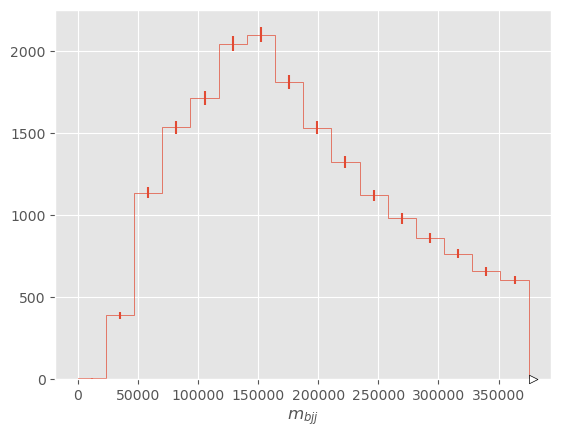

In [7]:
# perform computation and visualize
artists = hist_reco_mtop.compute().plot()

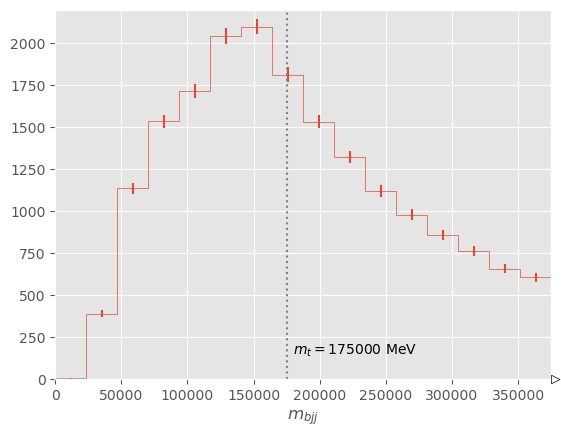

In [8]:
# and annotate the visualization
fig_dir = Path.cwd() / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

ax = artists[0].stairs.axes
fig = ax.get_figure()
ax.vlines(175000, 0, 2200, colors=["grey"], linestyle="dotted") 
ax.text(180000, 150, "$m_{t} = 175000$ MeV")
ax.set_xlim([0, 375000])
ax.set_ylim([0, 2200])

fig.savefig(fig_dir / "trijet_mass.png", dpi=300)
fig

## Now do the same with dataset tools

In [9]:
# for UChicago
# update this to point to your own client!
client = Client("tls://localhost:8786")

In [10]:
filenames_singletop_schan_lept_top = [
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621215._000011.pool.root.1"    
]

filenames_singletop_schan_lept_antitop = [
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621217._000012.pool.root.1"
]

filenames_tchan_BW50_lept_top = [
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621204._000012.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621204._000013.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621204._000014.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621204._000015.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621204._000016.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621204._000017.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621204._000018.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621204._000019.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621204._000020.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621204._000021.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621204._000022.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621204._000023.pool.root.1"
]

filenames_tchan_BW50_lept_antitop = [
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621209._000012.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621209._000013.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621209._000014.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621209._000015.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621209._000016.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621209._000017.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621209._000018.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621209._000019.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621209._000020.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621209._000021.pool.root.1"
]

filenames_tW_dyn_DR_incl_antitop = [
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000014.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000015.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000016.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000017.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000018.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000020.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000021.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000022.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000023.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000024.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000025.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000026.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000027.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000028.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000029.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000030.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000031.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000032.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000033.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000034.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000035.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000036.pool.root.1"
]


filenames_tW_dyn_DR_incl_top = [
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000087.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000088.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000090.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000092.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000093.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000098.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000099.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000101.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000102.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000103.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000104.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000106.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000107.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000108.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000109.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000110.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000111.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000113.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000114.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000115.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000116.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000122.pool.root.1"
]


fileset = {
            "singletop_schan_lept_top"  : 
                        {
                        'files': {name:'CollectionTree' for name in filenames_singletop_schan_lept_top},
                        },
            "singletop_schan_lept_antitop":
                        {
                        'files': {name:'CollectionTree' for name in filenames_singletop_schan_lept_antitop},
                        },
            "tchan_BW50_lept_top":
                        {
                        'files': {name:'CollectionTree' for name in filenames_tchan_BW50_lept_top},
                        },
            "tchan_BW50_lept_antitop":
                        {
                        'files': {name:'CollectionTree' for name in filenames_tchan_BW50_lept_antitop},
                        },
            "tW_dyn_DR_incl_antitop":
                        {
                        'files': {name:'CollectionTree' for name in filenames_tW_dyn_DR_incl_antitop},
                        },
            "tW_dyn_DR_incl_top":
                        {
                        'files': {name:'CollectionTree' for name in filenames_tW_dyn_DR_incl_top},
                        }
          }
        

samples, _ = dataset_tools.preprocess(fileset)

In [11]:
def create_histogram(events):
    
    
    # pT > 30 GeV for leptons, > 25 GeV for jets
    selected_electrons = events.Electrons[events.Electrons.pt > 30 & (np.abs(events.Electrons.eta) < 2.1)]
    selected_muons = events.Muons[events.Muons.pt > 30 & (np.abs(events.Muons.eta) < 2.1)]
    
    jets = events.Jets
    jets["btagDL1d"] = calculate_jets_btagDL1d(events)
    selected_jets = jets[events.Jets.pt > 25 & (np.abs(events.Jets.eta) < 2.4)] 

    # single lepton requirement
    event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
    # at least four jets
    event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
    # at least two b-tagged jets ("tag" means score above threshold)
    B_TAG_THRESHOLD = 2.456
    event_filters = event_filters & (ak.sum(selected_jets.btagDL1d < B_TAG_THRESHOLD, axis=1) >= 2)   
    
    # apply filters
    selected_jets = selected_jets[event_filters]
    
    trijet = ak.combinations(selected_jets, 3, fields=["j1", "j2", "j3"])  # trijet candidate
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # four-momentum of tri-jet system 
    
    
    trijet["max_btag"] = np.maximum(trijet.j1.btagDL1d, np.maximum(trijet.j2.btagDL1d, trijet.j3.btagDL1d))
    trijet = trijet[trijet.max_btag < B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
    
    trijet = trijet[ak.count(trijet.p4.pt, axis=1) > 0] # remove empty arrays. The empty arrays may occur due to the b tag selection
    
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    
    reconstructed_top_mass = ak.flatten(trijet_mass)
    
    hist_reco_mtop = hist.dask.Hist.new.Reg(16, 0, 375000, label="$m_{bjj}$").Double().fill(reconstructed_top_mass)
  
    
    return {"hist_mtop": hist_reco_mtop}
    

In [12]:
tasks = dataset_tools.apply_to_fileset(create_histogram, 
                                       samples, 
                                       schemaclass=PHYSLITESchema,
                                       uproot_options=dict(filter_name=filter_name)
                                      )

In [13]:
%%time

# execute
(out, ) = dask.compute(tasks)

CPU times: user 641 ms, sys: 11.5 ms, total: 652 ms
Wall time: 2min 1s


In [14]:
print(out.keys())

dict_keys(['singletop_schan_lept_top', 'singletop_schan_lept_antitop', 'tchan_BW50_lept_top', 'tchan_BW50_lept_antitop', 'tW_dyn_DR_incl_antitop', 'tW_dyn_DR_incl_top'])


In [15]:
print([out["singletop_schan_lept_top"]["hist_mtop"]])

[Hist(Regular(16, 0, 375000, label='$m_{bjj}$'), storage=Double()) # Sum: 54073.0 (65597.0 with flow)]


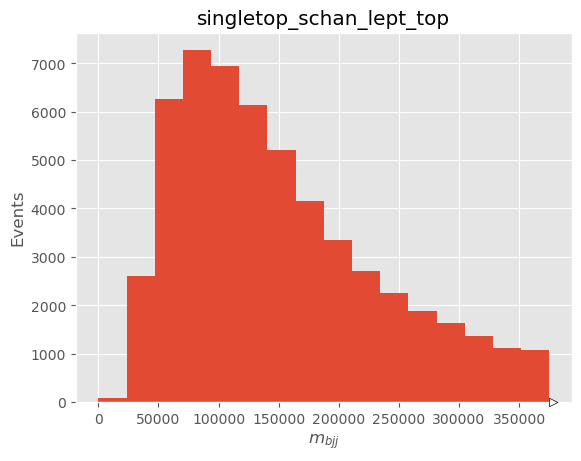

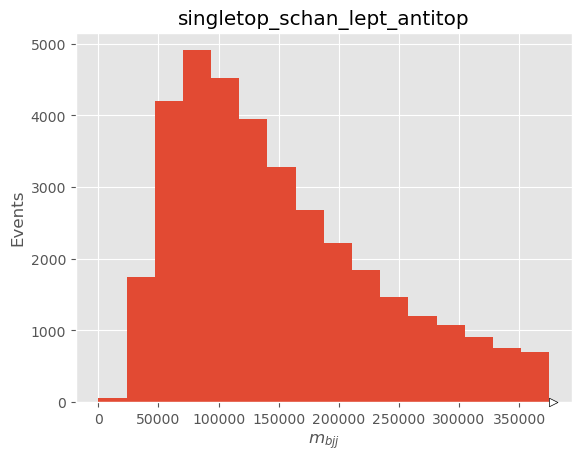

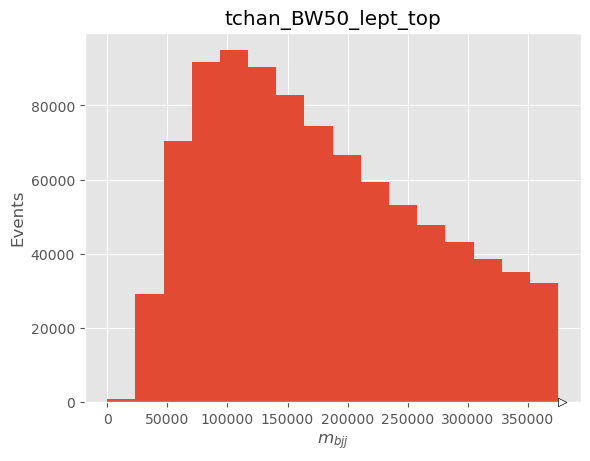

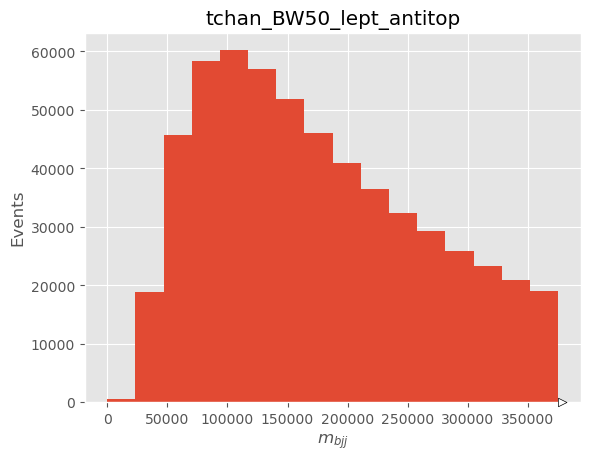

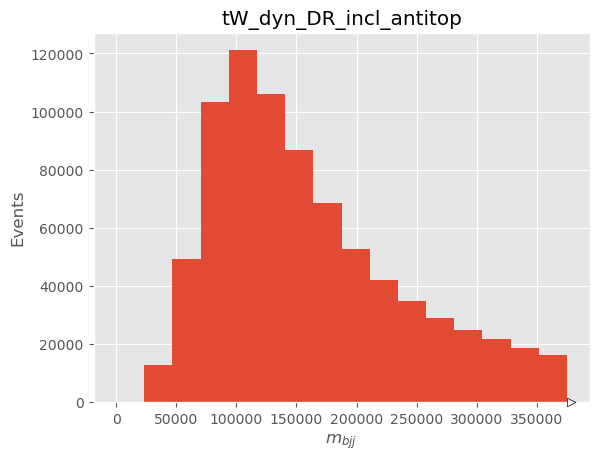

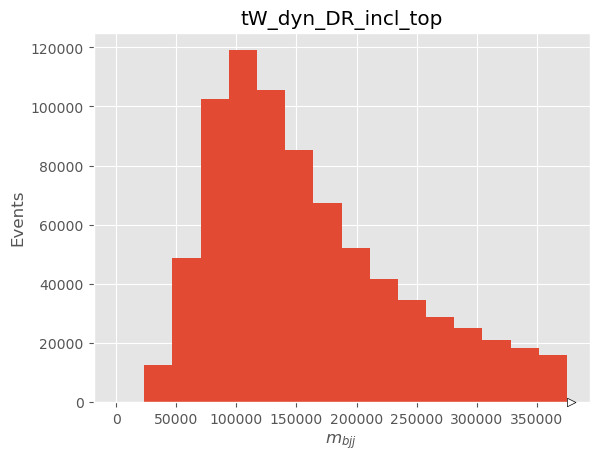

In [16]:
for proc_name in out.keys():

    # stack all the histograms together, as we processed each file separately
    full_histogram = sum( [out[proc_name]["hist_mtop"]] )

    # plot

    plt.figure()
    artists = full_histogram.plot(histtype="fill")

    ax = artists[0].stairs.axes
    ax.set_ylabel("Events");
    ax.set_title(proc_name)